In [2]:
import numpy as np
import keras
from keras.applications import VGG16
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
import os
import pathlib
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from livelossplot.inputs.keras import PlotLossesCallback

In [3]:
data_dir = pathlib.Path('images').with_suffix('')

chris_hemsworth = list(data_dir.glob('chris_hemsworth/*.jp*'))
liam_hemsworth = list(data_dir.glob('liam_hemsworth/*.jp*'))
katy_perry = list(data_dir.glob('katy_perry/*.jp*'))
zooey_deschanel = list(data_dir.glob('zooey_deschanel/*.jp*'))

print(f'Amount of images of chris hemsworth: {len(chris_hemsworth)}')
print(f'Amount of images of liam hemsworth: {len(liam_hemsworth)}')
print(f'Amount of images of katy perry: {len(katy_perry)}')
print(f'Amount of images of zooey deschanel: {len(zooey_deschanel)}')

Amount of images of chris hemsworth: 20
Amount of images of liam hemsworth: 10
Amount of images of katy perry: 20
Amount of images of zooey deschanel: 10


In [4]:
def extract_images(image_paths_list: list):
    images = []
    for image_paths in image_paths_list:
        for image_path in image_paths:
            img = cv2.imread(str(image_path))
            # resize the image to a max_width or max_height of 500px and keep the aspect ratio
            max_width = 500
            height, width = img.shape[:2]
            if width > max_width:
                scale_factor = max_width / width
                img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))
            max_height = 500
            if height > max_height:
                scale_factor = max_height / height
                img = cv2.resize(img, (int(width * scale_factor), int(height * scale_factor)))
            images.append(img)
    return images

In [5]:
images = extract_images([chris_hemsworth, katy_perry])
copy_images = extract_images([chris_hemsworth, katy_perry])

In [8]:
print(cv2.data.haarcascades)

/Users/peterbuschenreiter/Documents/KDG/Year 3/Data & AI 5/deep-learning/venv/lib/python3.10/site-packages/cv2/data/


In [9]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

In [10]:
images_found = 0
image_face_locations = []
for i, image in enumerate(images):
    face_locations = face_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(80, 80))
    image_face_locations.append(face_locations)

    if len(face_locations) == 0:
        print(f'No faces found in image {i}')
    else:
        images_found += 1
    for (x, y, w, h) in face_locations:
        cv2.rectangle(images[i], (x, y), (x + w, y + h), (0, 255, 0), 4)

print(f'Images found: {images_found}')
# get amount of instances with multiple faces
multiple_faces = 0
for i, face_locations in enumerate(image_face_locations):
    if len(face_locations) > 1:
        multiple_faces += 1
print(f'Multiple faces found: {multiple_faces}')

Images found: 40
Multiple faces found: 2


In [11]:
images_colored = []
for image in images:
    images_colored.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

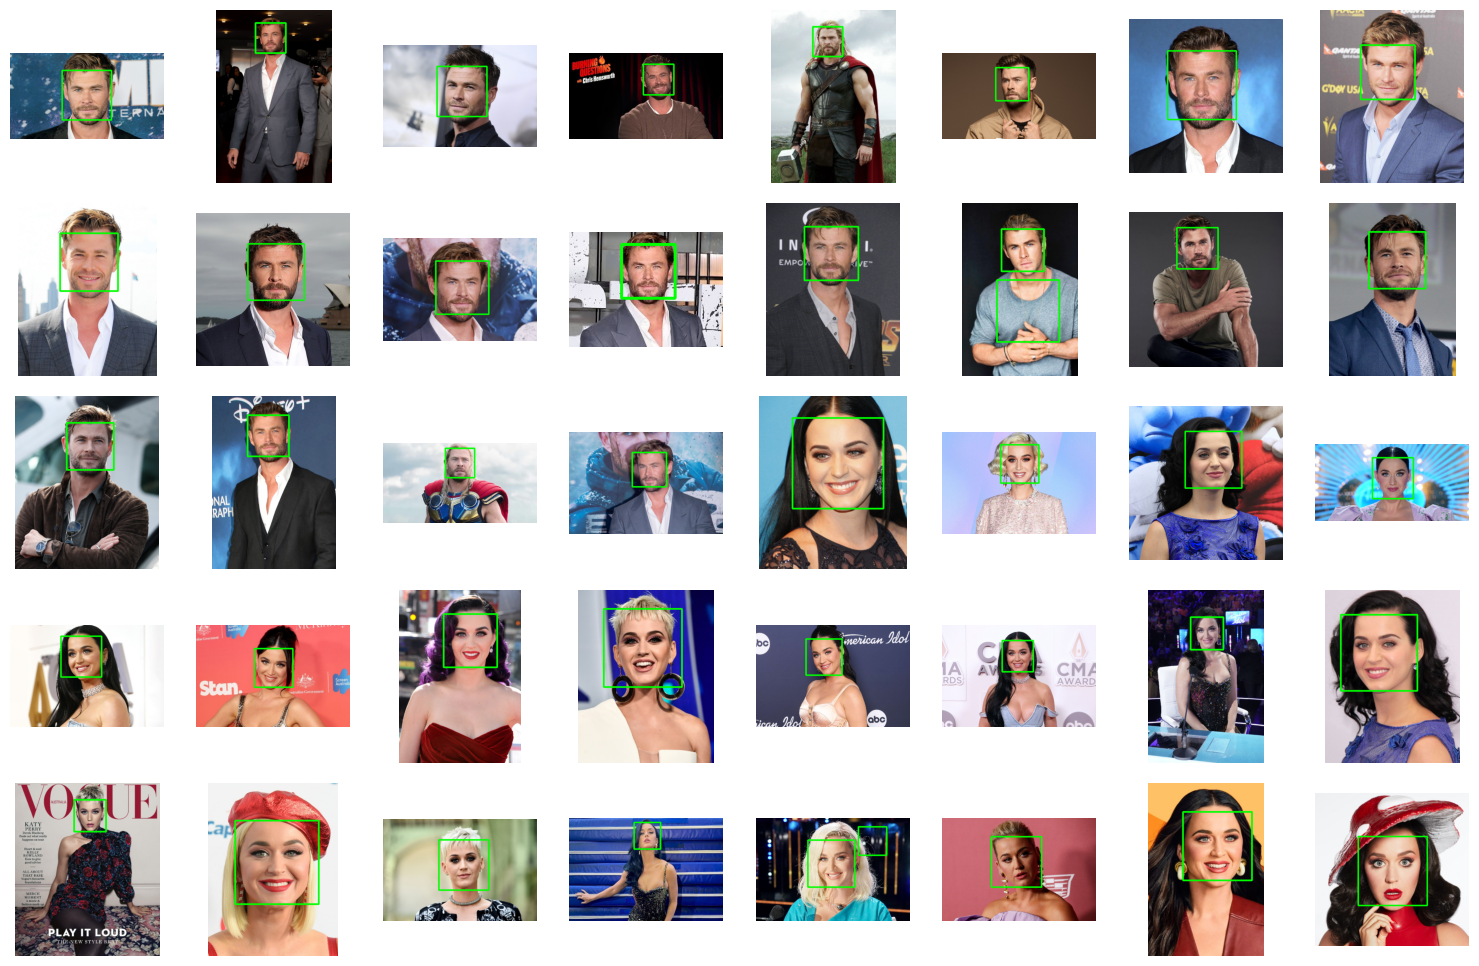

In [12]:
plt.figure(figsize=(15, 10))
for i, image in enumerate(images_colored):
    ax = plt.subplot(5, 8, i + 1)
    plt.tight_layout()
    plt.imshow(image)
    plt.axis("off")
plt.show()

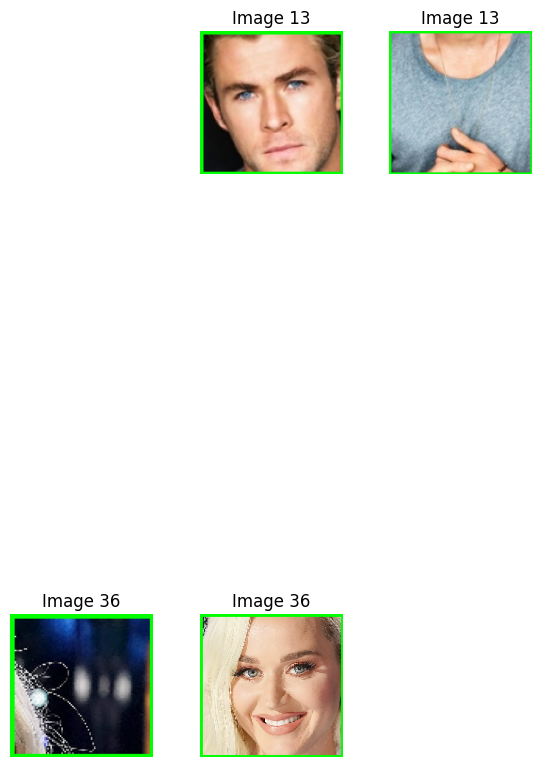

In [13]:
# show the images with multiple faces
plt.figure(figsize=(15, 10))
for i, face_locations in enumerate(image_face_locations):
    if len(face_locations) > 1:
        img = None
        for j, (x, y, w, h) in enumerate(face_locations):
            img = images_colored[i][y:y + h, x:x + w]
            ax = plt.subplot(5, 8, i + j + 1)
            plt.tight_layout()
            plt.imshow(img)
            plt.title(f'Image {i}')
            plt.axis("off")


In [14]:
# manually remove the images with multiple faces
image_face_locations[13] = np.array([np.delete(image_face_locations[13], [4, 5, 6, 7])])
image_face_locations[36] = np.array([np.delete(image_face_locations[36], [0, 1, 2, 3])])

In [15]:
images_copy_colored = []
for image in copy_images:
    images_copy_colored.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

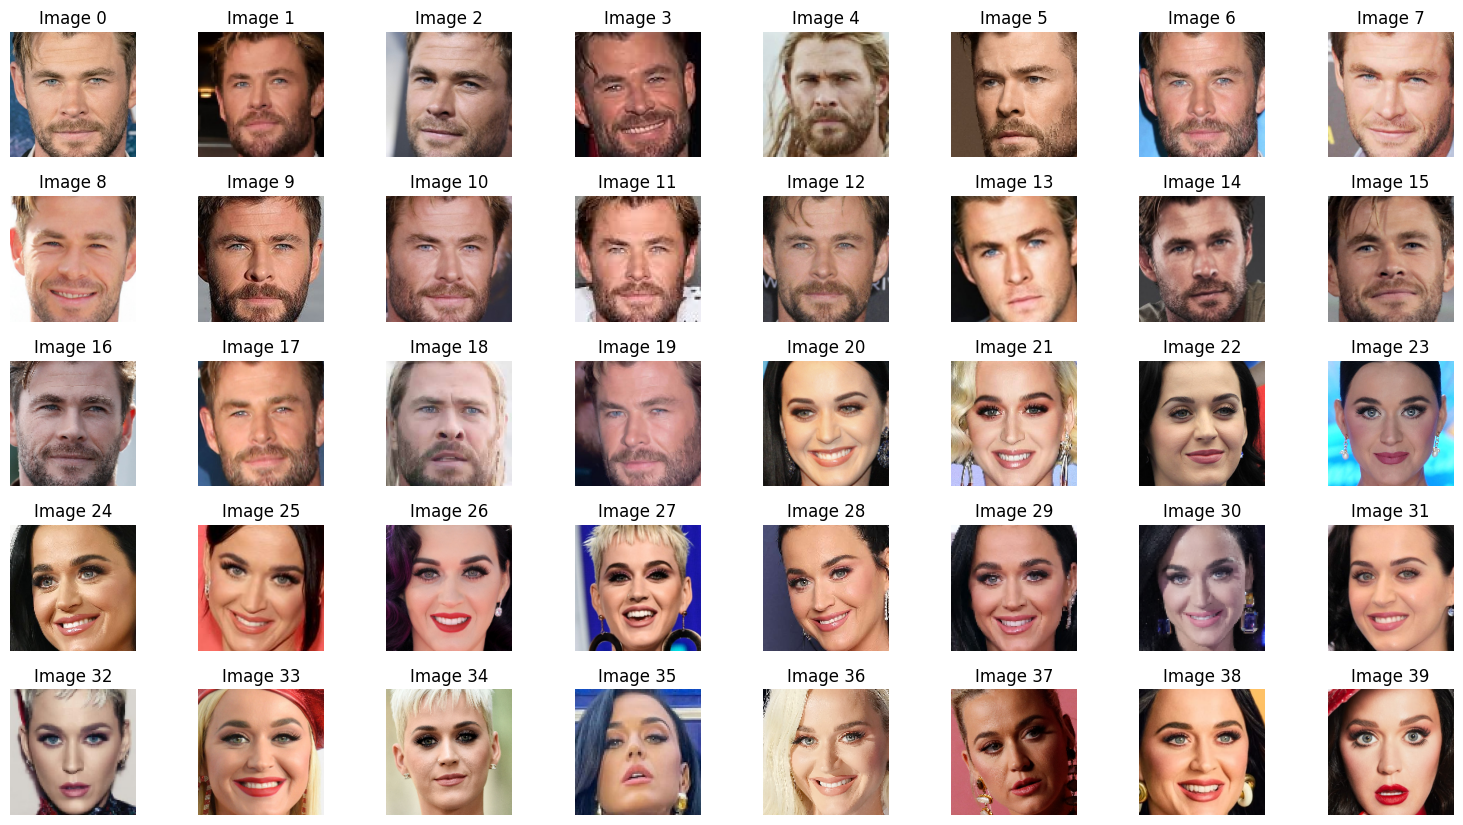

In [16]:
cropped_images = []
for i, image in enumerate(images_copy_colored):
    for (x, y, w, h) in image_face_locations[i]:
        cropped_images.append(image[y:y + h, x:x + w])

plt.figure(figsize=(15, 10))
for i, image in enumerate(cropped_images):
    ax = plt.subplot(6, 8, i + 1)
    plt.tight_layout()
    plt.imshow(image)
    plt.title(f'Image {i}')
    plt.axis("off")

In [17]:
# save the cropped images to a folder called training_data
for i, image in enumerate(cropped_images):
    sub_folder = 'chris_hemsworth' if i < 20 else 'katy_perry'
    if not os.path.exists(f'training_data/{sub_folder}'):
        os.makedirs(f'training_data/{sub_folder}')
    cv2.imwrite(f'training_data/{sub_folder}/image_{i}.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [18]:
# resize the images to 224x224
resized_images = np.array([cv2.resize(image, (224, 224)) for image in cropped_images])
resized_images.shape

(40, 224, 224, 3)

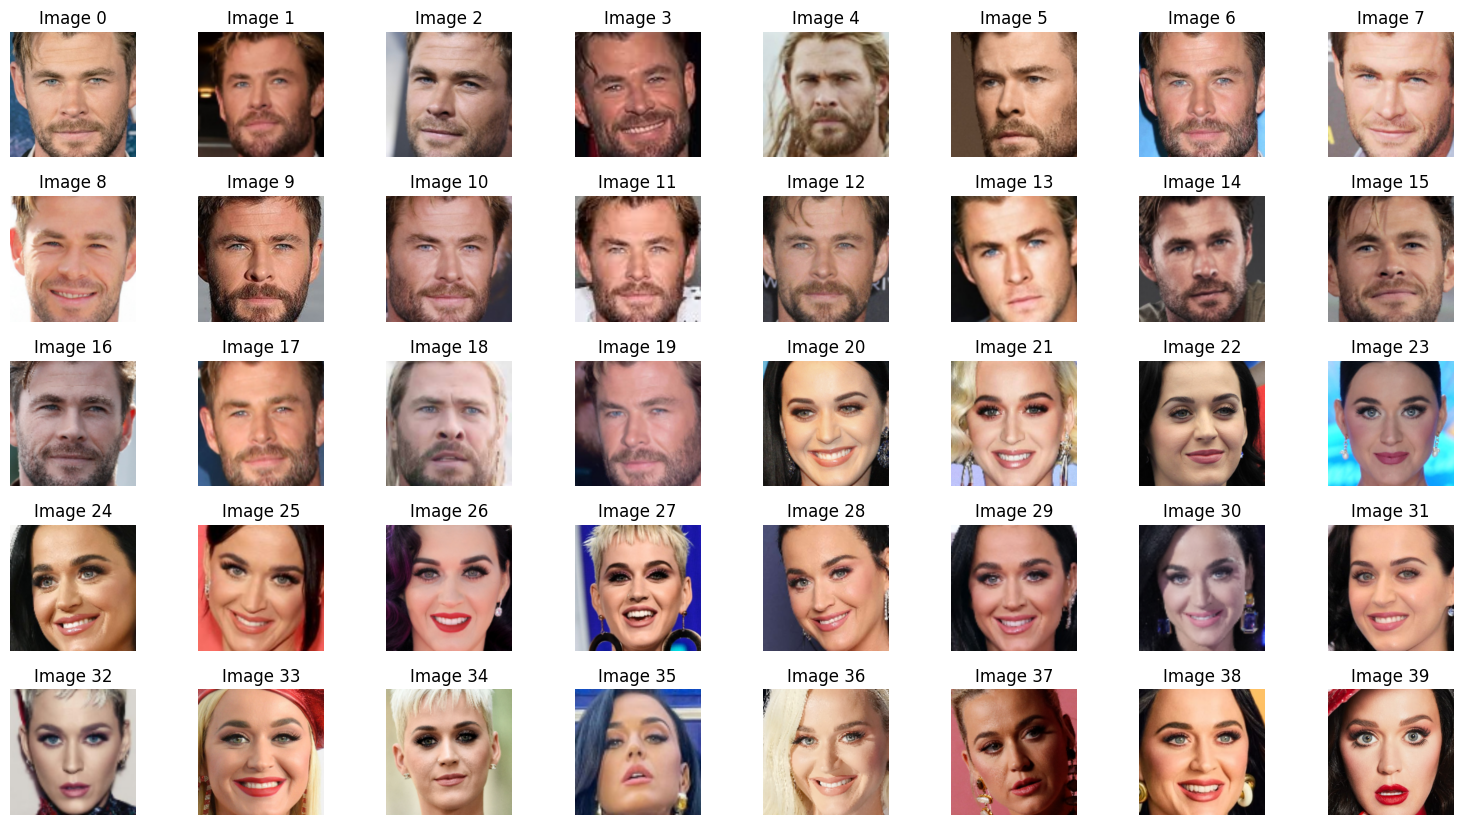

In [19]:
plt.figure(figsize=(15, 10))
for i, image in enumerate(resized_images):
    ax = plt.subplot(6, 8, i + 1)
    plt.tight_layout()
    plt.imshow(image)
    plt.title(f'Image {i}')
    plt.axis("off")

# The fun stuff

### Loading the data

In [20]:
data_dir = pathlib.Path('training_data').with_suffix('')
[train_ds, val_ds] = keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),
    validation_split=0.2,
    subset="both",
    seed=42)

Found 40 files belonging to 2 classes.
Using 32 files for training.
Using 8 files for validation.


In [22]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [430]:
data_dir = pathlib.Path('testing_data').with_suffix('')
test_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),
    seed=42)

Found 20 files belonging to 2 classes.


### Loading the model

In [413]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [414]:
base_model.trainable = False

In [452]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

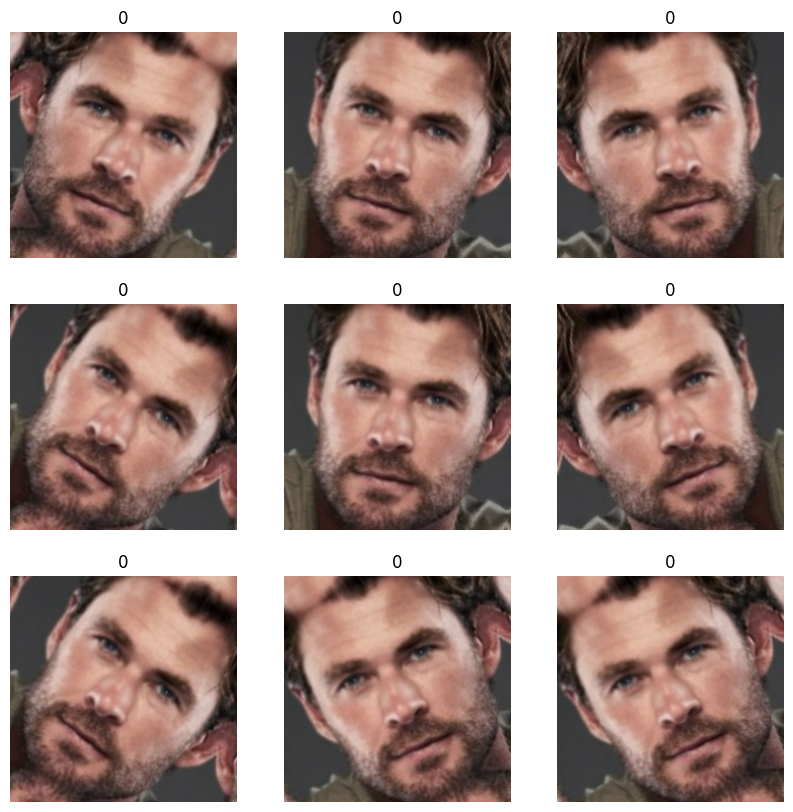

In [455]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(str(int(labels[0])))
        plt.axis("off")

In [619]:
inputs = keras.Input(shape=(224, 224, 3))
# Augment images
x = data_augmentation(inputs)
# We make sure that the base_model is running in inference mode here, by passing `training=False`. This is important for fine-tuning.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [620]:
model.compile(optimizer=keras.optimizers.legacy.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

In [621]:
plot_loss_1 = PlotLossesCallback()

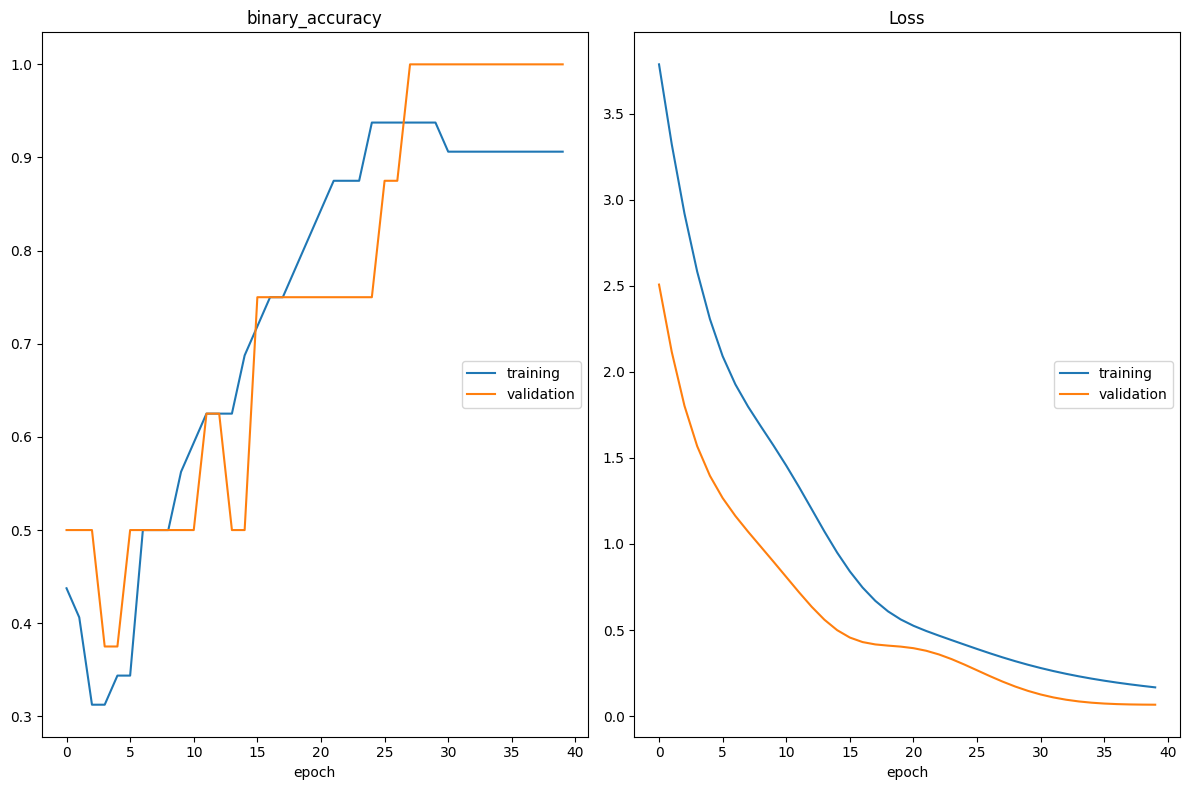

binary_accuracy
	training         	 (min:    0.312, max:    0.938, cur:    0.906)
	validation       	 (min:    0.375, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.167, max:    3.786, cur:    0.167)
	validation       	 (min:    0.066, max:    2.506, cur:    0.066)
1/1 [==============================] - 5s 5s/step - loss: 0.1672 - binary_accuracy: 0.9062 - val_loss: 0.0665 - val_binary_accuracy: 1.0000


In [622]:
model.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[plot_loss_1])

In [623]:
model.evaluate(test_ds, return_dict=True)

1/1 [==============================] - 2s 2s/step - loss: 0.3449 - binary_accuracy: 0.8500


{'loss': 0.34490853548049927, 'binary_accuracy': 0.8500000238418579}

1/1 [==============================] - 0s 131ms/step


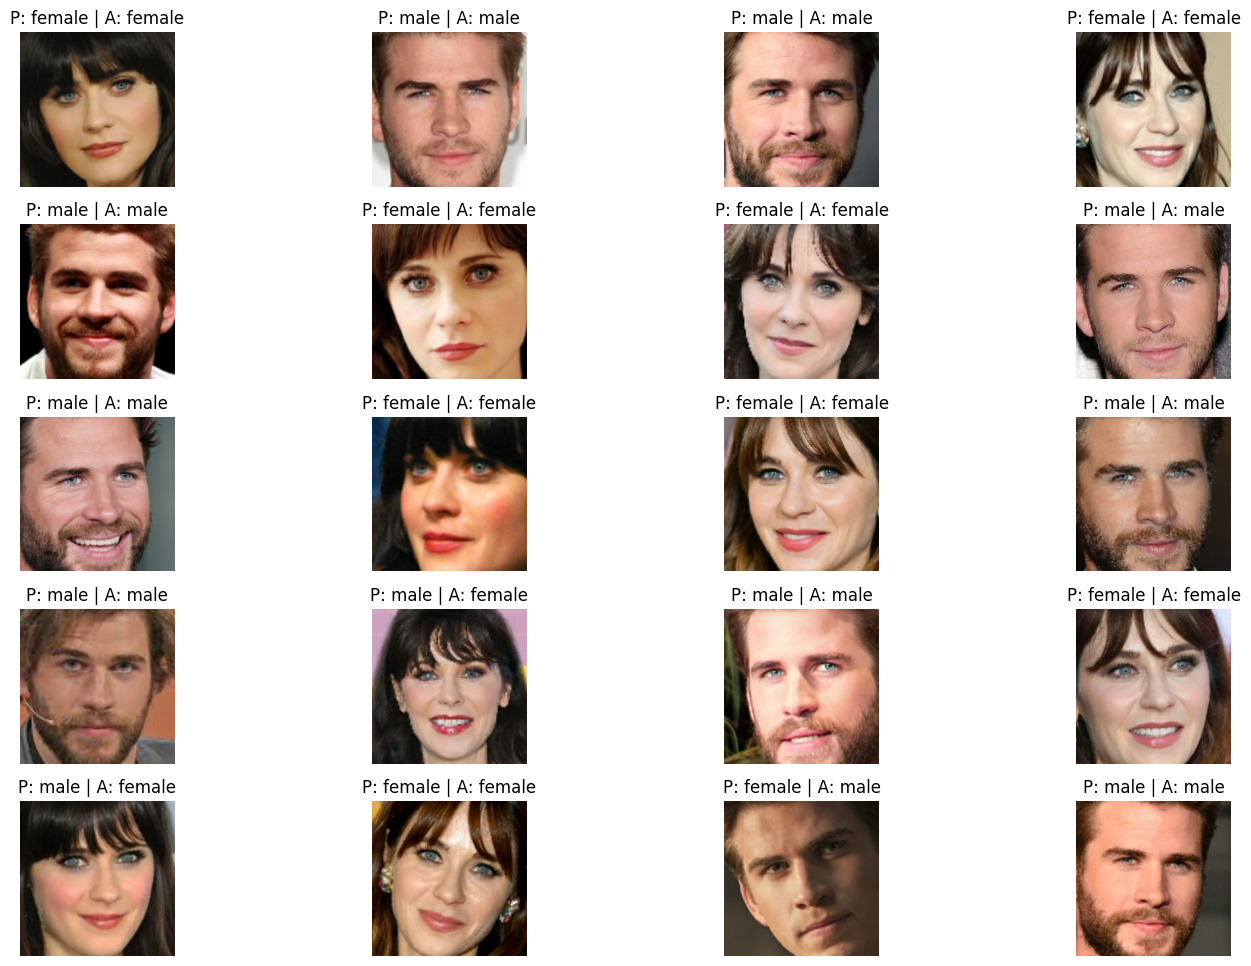

In [624]:
classes = np.array(['male', 'female'])
plt.figure(figsize=(15, 10))
for images, labels in test_ds:
    for i, [image, label] in enumerate(zip(images, labels)):
        prediction = model.predict(np.array([image]))
        ax = plt.subplot(5, 4, i + 1)
        plt.tight_layout()
        plt.imshow(image.numpy().astype("uint8"))
        prediction_idx = 1 if prediction[0][0] > 0.5 else 0
        plt.title(f'P: {classes[prediction_idx]} | A: {classes[int(label)]}')
        plt.axis("off")


1/1 [==============================] - 0s 122ms/step


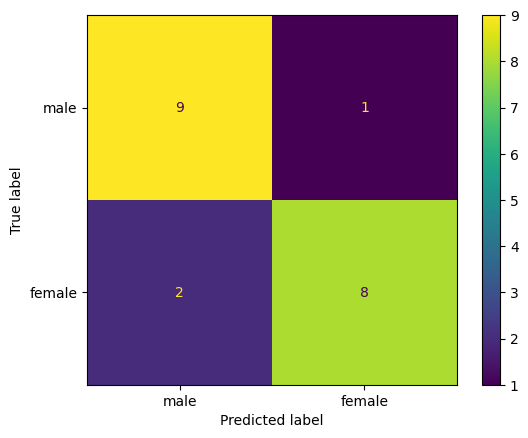

In [625]:
# display a confusion matrix
y_pred = []
y_true = []
for images, labels in test_ds:
    for i, [image, label] in enumerate(zip(images, labels)):
        prediction = model.predict(np.array([image]))
        prediction_idx = 1 if prediction[0][0] > 0.5 else 0
        y_pred.append(prediction_idx)
        y_true.append(int(label))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()

# Breaking the classifier

In [597]:
breaking_data = keras.utils.image_dataset_from_directory(
    'breaking_data',
    image_size=(224, 224),
    seed=42)


Found 4 files belonging to 2 classes.


1/1 [==============================] - 0s 133ms/step


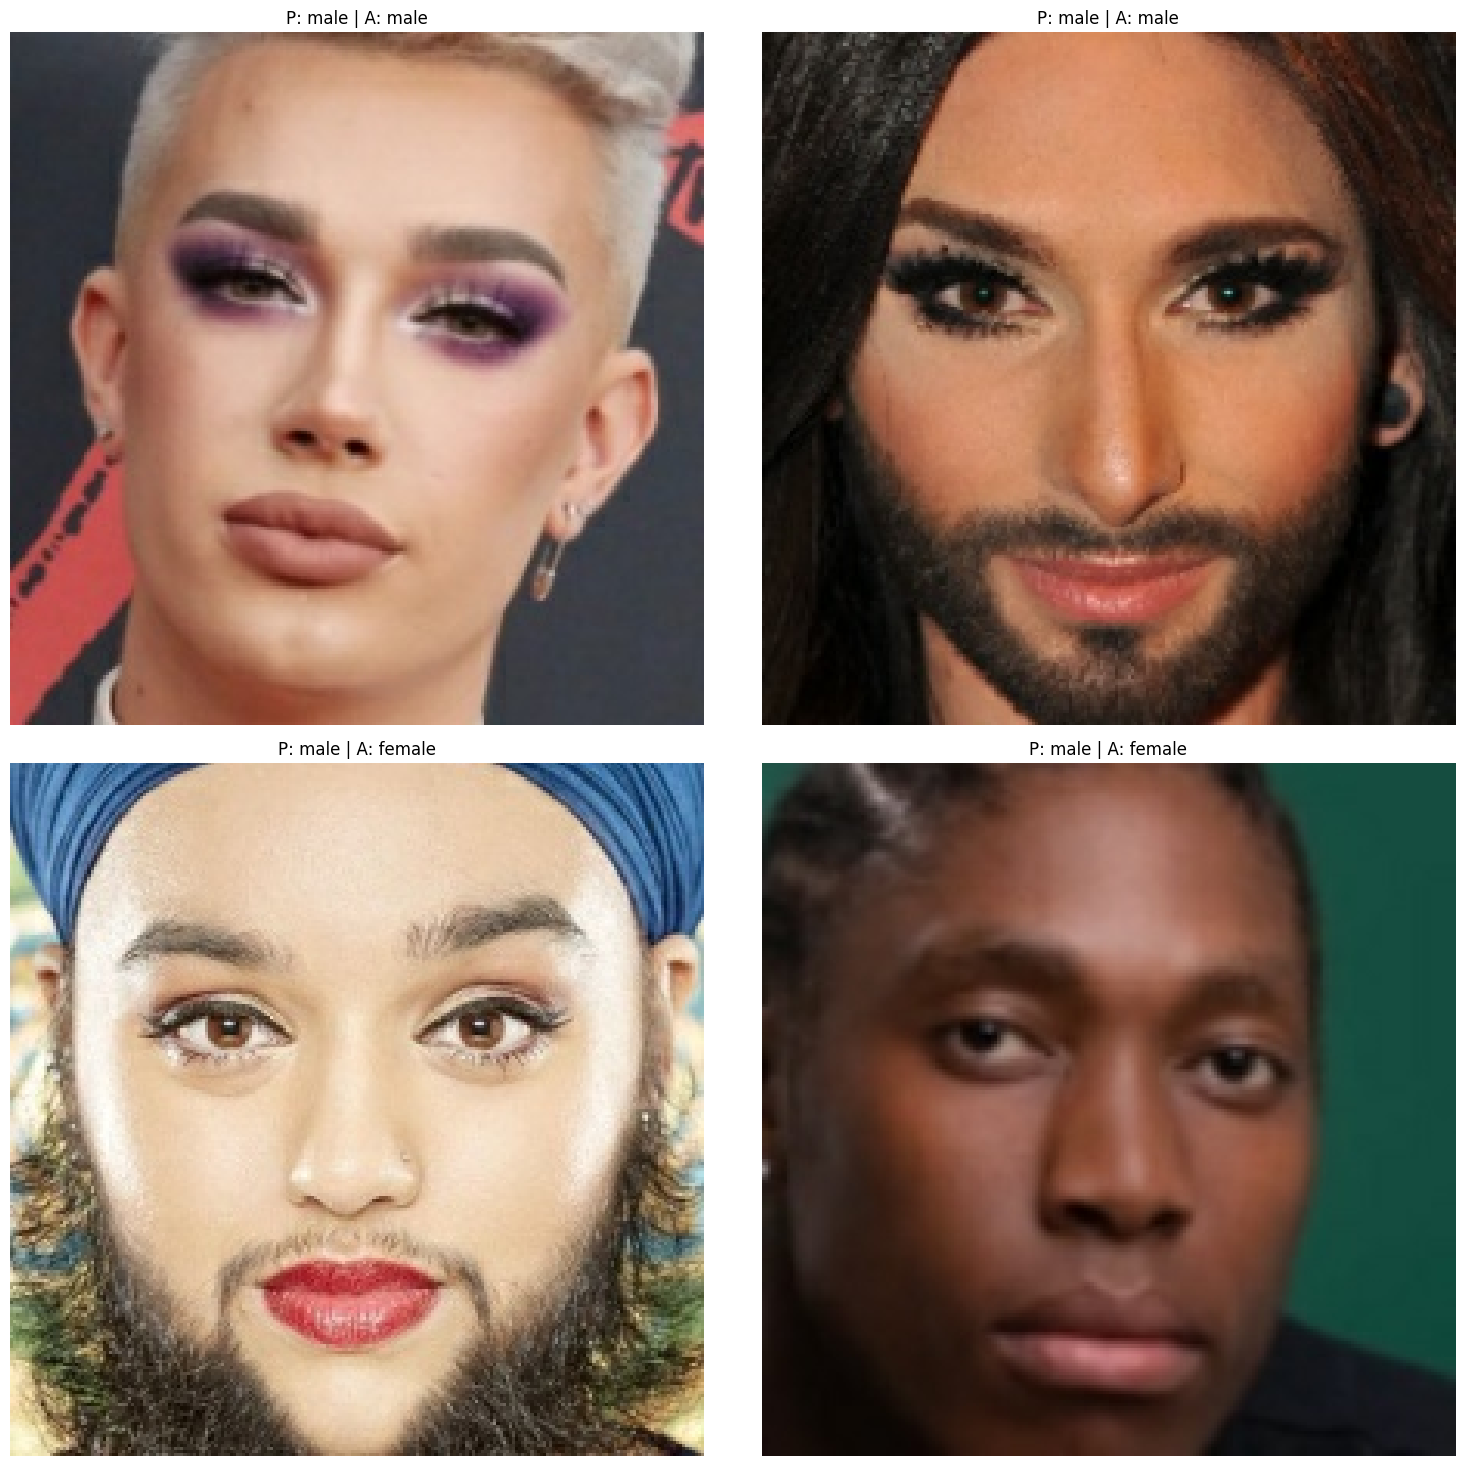

In [598]:
plt.figure(figsize=(15, 15))
for images, labels in breaking_data:
    for i, [image, label] in enumerate(zip(images, labels)):
        prediction = model.predict(np.array([image]))
        ax = plt.subplot(2, 2, i + 1)
        plt.tight_layout()
        plt.imshow(image.numpy().astype("uint8"))
        prediction_idx = 1 if prediction[0][0] > 0.5 else 0
        plt.title(f'P: {breaking_data.class_names[prediction_idx]} | A: {breaking_data.class_names[int(label)]}')
        plt.axis("off")

Both men get predicted as male, which seems to indicate that makeup isn't a strong predictor.
Both females get predicted as male as well, which is probably due to the beard on the first image (which seems to be a very strong predictor) and just the fact that Semenya has a very masculine physique, even causing confusion for humans (coupled with the lower representation of black people in datasets that models like VGG16 get trained upon, which makes it more difficult to classify them).